## Replication of Earnings Streak Paper

### Prereqs

##### Load packages and such

In [1]:
import os
from datetime import date
from functools import partial
from pathlib import Path
import sys
from dotenv import load_dotenv
import os

load_dotenv()

sys.path.append(os.getenv("ROOT"))

In [2]:
import pandas as pd
import numpy as np
import polars as pl

import silverfund.data_access_layer as dal
from silverfund.enums import Interval

##### Merges

In [3]:
epsData = pl.read_csv(
    r"/home/porter77/earnings-streak/sf-trading-system/research/example/streaks/usa-eps-92to25.csv"
)
print(epsData["anndats"].describe())
# epsData=epsData.filter(pl.col('USFIRM')==1)
epsData.sort(["OFTIC", "anndats"])

shape: (4, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ str        │
╞════════════╪════════════╡
│ count      ┆ 680486     │
│ null_count ┆ 0          │
│ min        ┆ 1992-04-21 │
│ max        ┆ 2025-02-20 │
└────────────┴────────────┘


TICKER,OFTIC,MEASURE,FISCALP,PYEAR,PMON,USFIRM,anndats,actual,surpmean,surpstdev,suescore
str,str,str,str,i64,i64,i64,str,f64,f64,f64,f64
"""CRAW/1""",null,"""EPS""","""QTR""",2001,12,1,"""2002-01-31""",null,0.13,null,null
"""CRAW/1""",null,"""EPS""","""QTR""",2002,3,1,"""2002-04-25""",0.17,0.17,null,null
"""CRAW/1""",null,"""EPS""","""QTR""",2002,6,1,"""2002-07-22""",0.1,0.13,null,null
"""RIGX""",null,"""EPS""","""ANN""",2016,12,1,"""2017-02-22""",0.426,0.42267,0.00122,2.72175
"""RIGX""",null,"""EPS""","""QTR""",2016,12,1,"""2017-02-22""",0.129,0.12589,0.00105,2.95144
…,…,…,…,…,…,…,…,…,…,…,…
"""SELY""","""ZZ""","""EPS""","""QTR""",2012,2,1,"""2012-03-27""",0.02,-0.02143,0.0241,1.71881
"""SELY""","""ZZ""","""EPS""","""QTR""",2012,5,1,"""2012-06-26""",0.03,-0.00143,0.01574,1.99724
"""SELY""","""ZZ""","""EPS""","""QTR""",2012,8,1,"""2012-09-27""",0.0,0.0325,0.00886,-3.66652


In [4]:
from datetime import datetime

start_date = datetime.strptime("2018-01-01", "%Y-%m-%d").date()

crspData = dal.load_crsp(interval=Interval.DAILY, start_date=start_date)
crspData

Loading CRSP Daily: 100%|██████████| 8/8 [00:00<00:00, 11.21it/s]


permno,permco,date,ncusip,ticker,shrcd,exchcd,siccd,prc,ret,retx,vol,shrout,cfacshr
i64,i64,date,str,str,i64,i64,i64,f64,f64,f64,f64,f64,f64
10026,7976,2018-01-02,"""46603210""","""JJSF""",11,3,2052,149.17999,-0.017454,-0.017454,190618.0,18668.0,1.0
10026,7976,2018-01-03,"""46603210""","""JJSF""",11,3,2052,147.69,-0.009988,-0.009988,63693.0,18668.0,1.0
10026,7976,2018-01-04,"""46603210""","""JJSF""",11,3,2052,149.73,0.013813,0.013813,127552.0,18668.0,1.0
10026,7976,2018-01-05,"""46603210""","""JJSF""",11,3,2052,148.3,-0.00955,-0.00955,44647.0,18668.0,1.0
10026,7976,2018-01-08,"""46603210""","""JJSF""",11,3,2052,148.41,0.000742,0.000742,55014.0,18668.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
93436,53453,2024-12-24,"""88160R10""","""TSLA""",11,3,9999,462.28,0.073572,0.073572,5.9351506e7,3.21006e6,1.0
93436,53453,2024-12-26,"""88160R10""","""TSLA""",11,3,9999,454.13,-0.01763,-0.01763,7.6392273e7,3.21006e6,1.0
93436,53453,2024-12-27,"""88160R10""","""TSLA""",11,3,9999,431.66,-0.049479,-0.049479,8.2370345e7,3.21006e6,1.0


In [5]:
mapping = pl.read_csv("ibes_to_cusip.csv")
mapping = mapping.rename({"CUSIP": "ncusip"})
mapping

TICKER,ncusip,OFTIC,CNAME,EXCHCD,COUNTRY,SDATES
str,str,str,str,str,str,str
"""0000""","""87482X10""","""TLMR""","""TALMER BANCORP INC""","""F""","""NA""","""2014-02-20"""
"""0000""","""87482X10""","""TLMR""","""TALMER BANCORP INC""","""F""","""NA""","""2014-03-20"""
"""0001""","""26878510""","""EPE""","""EP ENERGY CORP""","""A""","""NA""","""2014-02-20"""
"""0001""","""26878510""","""EPE""","""EP ENERGY CORP""","""A""","""NA""","""2014-03-20"""
"""0001""","""26878510""","""EPEG""","""EP ENERGY CORP""","""A""","""NA""","""2019-06-20"""
…,…,…,…,…,…,…
"""ZY""","""87254010""","""TJX""","""TJX COMPANIES INC""","""A""","""NA""","""2015-03-19"""
"""ZYNE""","""98986X10""","""ZYNE""","""ZYNERBA PHARMACEUTICALS INC""","""F""","""NA""","""2015-09-17"""
"""ZYNX""","""98986510""","""ZYNX""","""ZYNEX MEDICAL HOLDINGS INC""","""U""","""NA""","""2005-07-14"""


In [6]:
cusipEps = epsData.join(mapping, on=["TICKER", "OFTIC"])

cusipEps = cusipEps.with_columns(
    pl.col("anndats").str.strptime(pl.Date, format="%Y-%m-%d").alias("date")
)

In [7]:
totalMerge = cusipEps.join(crspData, on=["date", "ncusip"], how="right")
totalMerge = totalMerge.rename(
    {
        "surpmean": "expected",
        "FISCALP": "fiscalp",
        "USFIRM": "usfirm",
        "PMON": "periodmonth",
        "PYEAR": "periodyear",
    }
)
#'actual EPS':'actual','surpmean (expected)':'expected',

totalMerge

TICKER,OFTIC,MEASURE,fiscalp,periodyear,periodmonth,usfirm,anndats,actual,expected,surpstdev,suescore,CNAME,EXCHCD,COUNTRY,SDATES,permno,permco,date,ncusip,ticker,shrcd,exchcd,siccd,prc,ret,retx,vol,shrout,cfacshr
str,str,str,str,i64,i64,i64,str,f64,f64,f64,f64,str,str,str,str,i64,i64,date,str,str,i64,i64,i64,f64,f64,f64,f64,f64,f64
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,10026,7976,2018-01-02,"""46603210""","""JJSF""",11,3,2052,149.17999,-0.017454,-0.017454,190618.0,18668.0,1.0
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,10026,7976,2018-01-03,"""46603210""","""JJSF""",11,3,2052,147.69,-0.009988,-0.009988,63693.0,18668.0,1.0
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,10026,7976,2018-01-04,"""46603210""","""JJSF""",11,3,2052,149.73,0.013813,0.013813,127552.0,18668.0,1.0
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,10026,7976,2018-01-05,"""46603210""","""JJSF""",11,3,2052,148.3,-0.00955,-0.00955,44647.0,18668.0,1.0
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,10026,7976,2018-01-08,"""46603210""","""JJSF""",11,3,2052,148.41,0.000742,0.000742,55014.0,18668.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,93436,53453,2024-12-24,"""88160R10""","""TSLA""",11,3,9999,462.28,0.073572,0.073572,5.9351506e7,3.21006e6,1.0
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,93436,53453,2024-12-26,"""88160R10""","""TSLA""",11,3,9999,454.13,-0.01763,-0.01763,7.6392273e7,3.21006e6,1.0
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,93436,53453,2024-12-27,"""88160R10""","""TSLA""",11,3,9999,431.66,-0.049479,-0.049479,8.2370345e7,3.21006e6,1.0


In [8]:
totalMerge = totalMerge.select(
    [
        "actual",
        "expected",
        "fiscalp",
        "surpstdev",
        "suescore",
        "permno",
        "permco",
        "date",
        "ncusip",
        "ticker",
        "shrcd",
        "exchcd",
        "siccd",
        "prc",
        "ret",
        "retx",
        "vol",
        "shrout",
        "cfacshr",
        "periodmonth",
        "periodyear",
    ]
)
totalMerge = totalMerge.unique()

### Sign Porfolios

##### Make the signal (DAILY)

In [9]:
# filter out low prices

totalMerge = totalMerge.filter(
    (pl.col("prc") >= 5)
    & (
        (pl.col("fiscalp") == "QTR") | (pl.col("fiscalp").is_null())
    )  # only keep quarterly earnings bc some companies do both annual and quarter on the same day
)

In [10]:
totalMerge = totalMerge.sort(["ncusip", "date"])
totalMerge

actual,expected,fiscalp,surpstdev,suescore,permno,permco,date,ncusip,ticker,shrcd,exchcd,siccd,prc,ret,retx,vol,shrout,cfacshr,periodmonth,periodyear
f64,f64,str,f64,f64,i64,i64,date,str,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,i64,i64
null,null,null,null,null,14945,55038,2018-01-02,"""00030710""","""AAC""",11,1,6799,9.27,0.03,0.03,109632.0,23998.0,1.0,null,null
null,null,null,null,null,14945,55038,2018-01-03,"""00030710""","""AAC""",11,1,6799,9.25,-0.002158,-0.002158,129978.0,23998.0,1.0,null,null
null,null,null,null,null,14945,55038,2018-01-04,"""00030710""","""AAC""",11,1,6799,9.32,0.007568,0.007568,102183.0,23998.0,1.0,null,null
null,null,null,null,null,14945,55038,2018-01-05,"""00030710""","""AAC""",11,1,6799,9.12,-0.021459,-0.021459,97866.0,23998.0,1.0,null,null
null,null,null,null,null,14945,55038,2018-01-08,"""00030710""","""AAC""",11,1,6799,8.91,-0.023026,-0.023026,183873.0,23998.0,1.0,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
null,null,null,null,null,15857,55491,2024-12-24,"""Y9530810""","""WVE""",12,3,9999,13.41,0.022104,0.022104,350434.0,152143.0,1.0,null,null
null,null,null,null,null,15857,55491,2024-12-26,"""Y9530810""","""WVE""",12,3,9999,13.48,0.00522,0.00522,418580.0,152143.0,1.0,null,null
null,null,null,null,null,15857,55491,2024-12-27,"""Y9530810""","""WVE""",12,3,9999,12.9,-0.043027,-0.043027,590166.0,152143.0,1.0,null,null


In [11]:
totalMerge = totalMerge.with_columns((pl.col("actual") - pl.col("expected")).alias("surprise"))


totalMerge = totalMerge.with_columns(
    (pl.col("surprise") / pl.col("prc").shift(1).over("ncusip")).alias("raw_surpsignal")
)


totalMerge = totalMerge.with_columns(
    pl.col("raw_surpsignal").shift(1).over("ncusip").alias("surpsignal")
)

totalMerge

actual,expected,fiscalp,surpstdev,suescore,permno,permco,date,ncusip,ticker,shrcd,exchcd,siccd,prc,ret,retx,vol,shrout,cfacshr,periodmonth,periodyear,surprise,raw_surpsignal,surpsignal
f64,f64,str,f64,f64,i64,i64,date,str,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64
null,null,null,null,null,14945,55038,2018-01-02,"""00030710""","""AAC""",11,1,6799,9.27,0.03,0.03,109632.0,23998.0,1.0,null,null,null,null,null
null,null,null,null,null,14945,55038,2018-01-03,"""00030710""","""AAC""",11,1,6799,9.25,-0.002158,-0.002158,129978.0,23998.0,1.0,null,null,null,null,null
null,null,null,null,null,14945,55038,2018-01-04,"""00030710""","""AAC""",11,1,6799,9.32,0.007568,0.007568,102183.0,23998.0,1.0,null,null,null,null,null
null,null,null,null,null,14945,55038,2018-01-05,"""00030710""","""AAC""",11,1,6799,9.12,-0.021459,-0.021459,97866.0,23998.0,1.0,null,null,null,null,null
null,null,null,null,null,14945,55038,2018-01-08,"""00030710""","""AAC""",11,1,6799,8.91,-0.023026,-0.023026,183873.0,23998.0,1.0,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
null,null,null,null,null,15857,55491,2024-12-24,"""Y9530810""","""WVE""",12,3,9999,13.41,0.022104,0.022104,350434.0,152143.0,1.0,null,null,null,null,null
null,null,null,null,null,15857,55491,2024-12-26,"""Y9530810""","""WVE""",12,3,9999,13.48,0.00522,0.00522,418580.0,152143.0,1.0,null,null,null,null,null
null,null,null,null,null,15857,55491,2024-12-27,"""Y9530810""","""WVE""",12,3,9999,12.9,-0.043027,-0.043027,590166.0,152143.0,1.0,null,null,null,null,null


##### Cleaning earnings announcement duplicate dates

In [12]:
# Step 1: Create the filtered flag
totalMerge = totalMerge.with_columns(
    ((pl.col("surprise").is_not_null()) & (pl.col("surpsignal").is_not_null())).alias("is_match")
)

# Step 2: Shift the flag *backwards* to capture the previous row
totalMerge = totalMerge.with_columns(
    pl.col("is_match").shift(-1).over("ncusip").alias("next_row_is_match")
)

# Step 3: Keep rows where current OR next row is a match
filtered_with_prev = totalMerge.filter(pl.col("is_match") | pl.col("next_row_is_match")).sort(
    ["ncusip", "date"]
)

In [13]:
totalMerge = totalMerge.filter(
    (pl.col("is_match") == False) & (pl.col("next_row_is_match") == False)
)
totalMerge = totalMerge.drop(["is_match", "next_row_is_match"])
# getting around the fact that some firms announce multiple quarters on the same day

##### making sign and streak vars

In [14]:
totalMerge = totalMerge.with_columns(
    pl.when(pl.col("surpsignal") > 0).then(1).when(pl.col("surpsignal") <= 0).then(-1).alias("sign")
)


print(totalMerge["sign"].describe())

shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 89841.0     │
│ null_count ┆ 1.2142497e7 │
│ mean       ┆ 0.319709    │
│ std        ┆ 0.947521    │
│ min        ┆ -1.0        │
│ 25%        ┆ -1.0        │
│ 50%        ┆ 1.0         │
│ 75%        ┆ 1.0         │
│ max        ┆ 1.0         │
└────────────┴─────────────┘


In [15]:
subset = totalMerge.filter(pl.col("sign").is_not_null())
subset.sort(["ncusip", "date"])
subset = subset.with_columns(pl.col("sign").shift(1).over("ncusip").alias("prev_sign"))

subset = subset.with_columns(
    pl.when((pl.col("sign") == 1) & (pl.col("prev_sign") == 1))
    .then(1)
    .when((pl.col("sign") == -1) & (pl.col("prev_sign") == -1))
    .then(-1)
    .otherwise(0)
    .alias("streak")
)
subset

mergeStreaks = subset.select(["ncusip", "date", "streak"])
mergeStreaks

ncusip,date,streak
str,date,i32
"""00030710""",2018-02-22,0
"""00030710""",2018-05-03,1
"""00030710""",2018-08-03,0
"""00032Q10""",2021-11-11,0
"""00032Q10""",2022-03-18,0
…,…,…
"""Y9530810""",2023-11-10,1
"""Y9530810""",2024-03-07,1
"""Y9530810""",2024-05-10,0


In [16]:
totalMerge = totalMerge.join(mergeStreaks, on=["ncusip", "date"], how="left")

In [17]:
totalMerge = totalMerge.sort(["ncusip", "date"])
totalMerge

actual,expected,fiscalp,surpstdev,suescore,permno,permco,date,ncusip,ticker,shrcd,exchcd,siccd,prc,ret,retx,vol,shrout,cfacshr,periodmonth,periodyear,surprise,raw_surpsignal,surpsignal,sign,streak
f64,f64,str,f64,f64,i64,i64,date,str,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,i32,i32
null,null,null,null,null,14945,55038,2018-01-02,"""00030710""","""AAC""",11,1,6799,9.27,0.03,0.03,109632.0,23998.0,1.0,null,null,null,null,null,null,null
null,null,null,null,null,14945,55038,2018-01-03,"""00030710""","""AAC""",11,1,6799,9.25,-0.002158,-0.002158,129978.0,23998.0,1.0,null,null,null,null,null,null,null
null,null,null,null,null,14945,55038,2018-01-04,"""00030710""","""AAC""",11,1,6799,9.32,0.007568,0.007568,102183.0,23998.0,1.0,null,null,null,null,null,null,null
null,null,null,null,null,14945,55038,2018-01-05,"""00030710""","""AAC""",11,1,6799,9.12,-0.021459,-0.021459,97866.0,23998.0,1.0,null,null,null,null,null,null,null
null,null,null,null,null,14945,55038,2018-01-08,"""00030710""","""AAC""",11,1,6799,8.91,-0.023026,-0.023026,183873.0,23998.0,1.0,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
null,null,null,null,null,15857,55491,2024-12-23,"""Y9530810""","""WVE""",12,3,9999,13.12,-0.028868,-0.028868,852517.0,152143.0,1.0,null,null,null,null,null,null,null
null,null,null,null,null,15857,55491,2024-12-24,"""Y9530810""","""WVE""",12,3,9999,13.41,0.022104,0.022104,350434.0,152143.0,1.0,null,null,null,null,null,null,null
null,null,null,null,null,15857,55491,2024-12-26,"""Y9530810""","""WVE""",12,3,9999,13.48,0.00522,0.00522,418580.0,152143.0,1.0,null,null,null,null,null,null,null


##### make holdings

In [18]:
from datetime import timedelta
from tqdm import tqdm

# Get all trading dates
keys = sorted(totalMerge["date"].unique().to_list())
keys_set = set(keys)

# Build a dictionary mapping (date, ncusip) to return
returns_lookup = {
    (row["date"], row["ncusip"]): row["ret"]
    for row in totalMerge.select(["date", "ncusip", "ret"]).to_dicts()
}

# Initialize the long holdings dictionary
long_holdings_by_date = {k: [] for k in keys}

# Loop over all signal dates
for date in tqdm(keys, desc="Building long holdings"):
    sub = totalMerge.filter((pl.col("date") == date) & (pl.col("streak") == 1))
    ncusips = sub.select("ncusip").to_series().to_list()

    for i in range(183):  # roughly 6 months
        future_day = date + timedelta(days=i)
        if future_day not in keys_set:
            continue

        for ncusip in ncusips:
            ret = returns_lookup.get((future_day, ncusip))
            if ret is not None:
                long_holdings_by_date[future_day].append({"ncusip": ncusip, "ret": ret})

Building long holdings: 100%|██████████| 1760/1760 [00:40<00:00, 43.52it/s]


In [19]:
from datetime import timedelta
from tqdm import tqdm

# Get all trading dates
keys = sorted(totalMerge["date"].unique().to_list())
keys_set = set(keys)

# Build a dictionary mapping (date, ncusip) to return
returns_lookup = {
    (row["date"], row["ncusip"]): row["ret"]
    for row in totalMerge.select(["date", "ncusip", "ret"]).to_dicts()
}


short_holdings_by_date = {k: [] for k in keys}

# Loop over all signal dates
for date in tqdm(keys, desc="Building short holdings"):
    sub = totalMerge.filter((pl.col("date") == date) & (pl.col("streak") == -1))
    ncusips = sub.select("ncusip").to_series().to_list()

    for i in range(183):  # roughly 6 months
        future_day = date + timedelta(days=i)
        if future_day not in keys_set:
            continue

        for ncusip in ncusips:
            ret = returns_lookup.get((future_day, ncusip))
            if ret is not None:
                short_holdings_by_date[future_day].append({"ncusip": ncusip, "ret": ret})

Building short holdings: 100%|██████████| 1760/1760 [00:27<00:00, 63.59it/s]


In [20]:
from statistics import mean

long_mean_returns_by_date = {}

for date, holdings in long_holdings_by_date.items():
    # Dictionary to store the most recent return for each ncusip (or just first one)
    ret_by_ncusip = {}
    for entry in holdings:
        ncusip = entry["ncusip"]
        ret = entry["ret"]
        if ret is not None:
            ret_by_ncusip[ncusip] = ret  # overwrite or keep only one value per ncusip

    if ret_by_ncusip:
        long_mean_returns_by_date[date] = mean(ret_by_ncusip.values())
    else:
        long_mean_returns_by_date[date] = None  # or 0.0 if you prefer

In [21]:
from statistics import mean

short_mean_returns_by_date = {}

for date, holdings in short_holdings_by_date.items():
    # Dictionary to store the most recent return for each ncusip (or just first one)
    ret_by_ncusip = {}
    for entry in holdings:
        ncusip = entry["ncusip"]
        ret = entry["ret"]
        if ret is not None:
            ret_by_ncusip[ncusip] = ret  # overwrite or keep only one value per ncusip

    if ret_by_ncusip:
        short_mean_returns_by_date[date] = mean(ret_by_ncusip.values())
    else:
        short_mean_returns_by_date[date] = None  # or 0.0 if you prefer

In [22]:
pl.Config.set_tbl_rows(10)

short_n_holdings_by_date = {
    date: len(set(entry["ncusip"] for entry in holdings))
    for date, holdings in short_holdings_by_date.items()
}

import polars as pl

short = pl.DataFrame(
    {
        "date": list(short_n_holdings_by_date.keys()),
        "n_short_holdings": list(short_n_holdings_by_date.values()),
    }
).sort("date")


long_n_holdings_by_date = {
    date: len(set(entry["ncusip"] for entry in holdings))
    for date, holdings in long_holdings_by_date.items()
}

import polars as pl

long = pl.DataFrame(
    {
        "date": list(long_n_holdings_by_date.keys()),
        "n_long_holdings": list(long_n_holdings_by_date.values()),
    }
).sort("date")

total = long.join(short, on="date")
total = total.with_columns(
    (pl.col("n_long_holdings") + pl.col("n_short_holdings")).alias("total_holdings")
)
total

date,n_long_holdings,n_short_holdings,total_holdings
date,i64,i64,i64
2018-01-02,0,0,0
2018-01-03,0,0,0
2018-01-04,0,0,0
2018-01-05,0,0,0
2018-01-08,0,0,0
…,…,…,…
2024-12-23,1824,677,2501
2024-12-24,1826,680,2506
2024-12-26,1826,681,2507


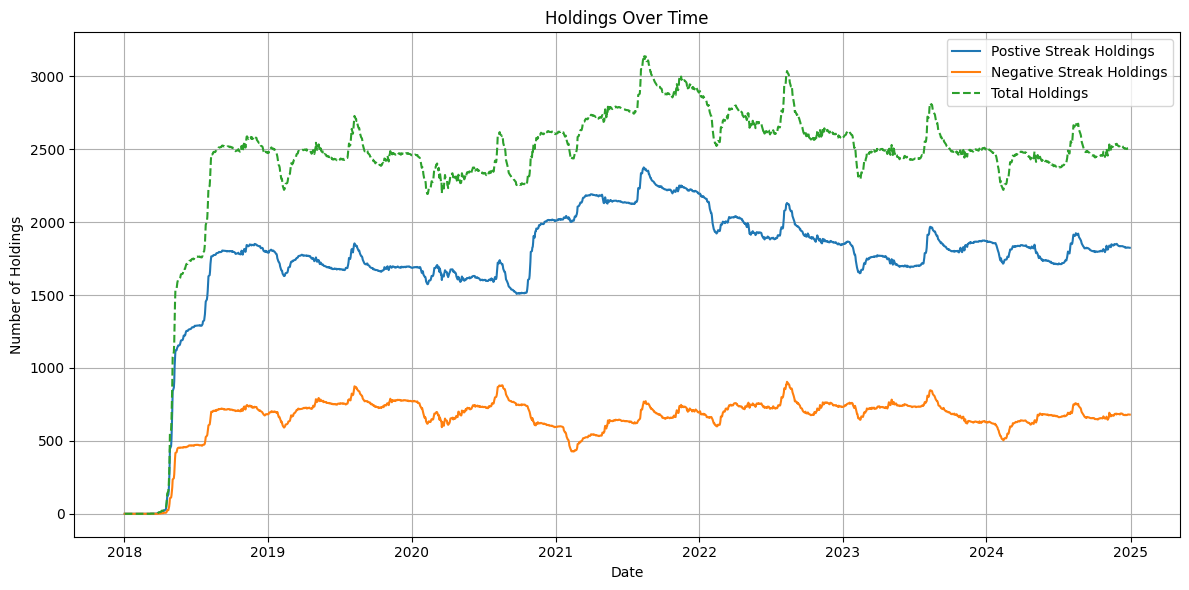

In [23]:
import matplotlib.pyplot as plt

# If your DataFrame is Polars:
df_pd = total.to_pandas()

plt.figure(figsize=(12, 6))

plt.plot(df_pd["date"], df_pd["n_long_holdings"], label="Postive Streak Holdings")
plt.plot(df_pd["date"], df_pd["n_short_holdings"], label="Negative Streak Holdings")
plt.plot(df_pd["date"], df_pd["total_holdings"], label="Total Holdings", linestyle="--")

plt.title("Holdings Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Holdings")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### portfolio returns

In [24]:
import polars as pl

ret = pl.DataFrame(
    {
        "date": keys,  # same keys used for both dictionaries
        "long_ret": [long_mean_returns_by_date.get(k) for k in keys],
        "short_ret": [short_mean_returns_by_date.get(k) for k in keys],
    }
).sort("date")


ret = ret.with_columns(((pl.col("long_ret")) - (pl.col("short_ret"))).alias("spread"))
ret

date,long_ret,short_ret,spread
date,f64,f64,f64
2018-01-02,null,null,null
2018-01-03,null,null,null
2018-01-04,null,null,null
2018-01-05,null,null,null
2018-01-08,null,null,null
…,…,…,…
2024-12-23,0.000724,-0.000957,0.001681
2024-12-24,0.008264,0.012057,-0.003793
2024-12-26,0.007072,0.008,-0.000928


In [25]:
import polars as pl

monthly_ret = (
    ret.with_columns([pl.col("date").dt.truncate("1mo").alias("month")])
    .with_columns(
        [
            pl.col("long_ret").cum_sum().over("month").alias("long_monthly_ret"),
            pl.col("short_ret").cum_sum().over("month").alias("short_monthly_ret"),
            pl.col("spread").cum_sum().over("month").alias("spread_monthly_ret"),
        ]
    )
    .group_by("month")
    .agg(
        [
            pl.last("date").alias("last_date_of_month"),
            pl.last("long_monthly_ret").alias("monthly_long_ret"),
            pl.last("short_monthly_ret").alias("monthly_short_ret"),
            pl.last("spread_monthly_ret").alias("monthly_spread_ret"),
        ]
    )
    .sort("month")
)


# note the monthly ret is in decimal space, the factors from diether are in percent space

monthly_ret = monthly_ret.with_columns((pl.col("monthly_long_ret") * 100).alias("monthly_long_ret"))
monthly_ret = monthly_ret.with_columns(
    (pl.col("monthly_short_ret") * 100).alias("monthly_short_ret")
)
monthly_ret = monthly_ret.with_columns(
    (pl.col("monthly_spread_ret") * 100).alias("monthly_spread_ret")
)


monthly_ret

month,last_date_of_month,monthly_long_ret,monthly_short_ret,monthly_spread_ret
date,date,f64,f64,f64
2018-01-01,2018-01-31,null,null,null
2018-02-01,2018-02-28,null,null,null
2018-03-01,2018-03-29,6.588868,-3.8035,4.340737
2018-04-01,2018-04-30,-0.703071,2.364108,-3.067179
2018-05-01,2018-05-31,5.865424,3.47895,2.386474
…,…,…,…,…
2024-08-01,2024-08-30,1.0537,-0.699326,1.753025
2024-09-01,2024-09-30,1.832941,1.675194,0.157747
2024-10-01,2024-10-31,-0.707054,0.138512,-0.845566


In [26]:
daily_returns = ret.with_columns(
    [
        pl.col("long_ret").fill_null(0).alias("long_ret_filled"),
        pl.col("short_ret").fill_null(0).alias("short_ret_filled"),
        pl.col("spread").fill_null(0).alias("spread_ret_filled"),
    ]
)

daily_returns = daily_returns.with_columns(
    [
        daily_returns["long_ret_filled"].cum_sum().alias("long_cumret"),
        daily_returns["short_ret_filled"].cum_sum().alias("short_cumret"),
        daily_returns["spread_ret_filled"].cum_sum().alias("spread_cumret"),
    ]
)
daily_returns

date,long_ret,short_ret,spread,long_ret_filled,short_ret_filled,spread_ret_filled,long_cumret,short_cumret,spread_cumret
date,f64,f64,f64,f64,f64,f64,f64,f64,f64
2018-01-02,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-04,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-05,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-08,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…
2024-12-23,0.000724,-0.000957,0.001681,0.000724,-0.000957,0.001681,1.233323,0.913819,0.258987
2024-12-24,0.008264,0.012057,-0.003793,0.008264,0.012057,-0.003793,1.241587,0.925876,0.255194
2024-12-26,0.007072,0.008,-0.000928,0.007072,0.008,-0.000928,1.248659,0.933877,0.254266


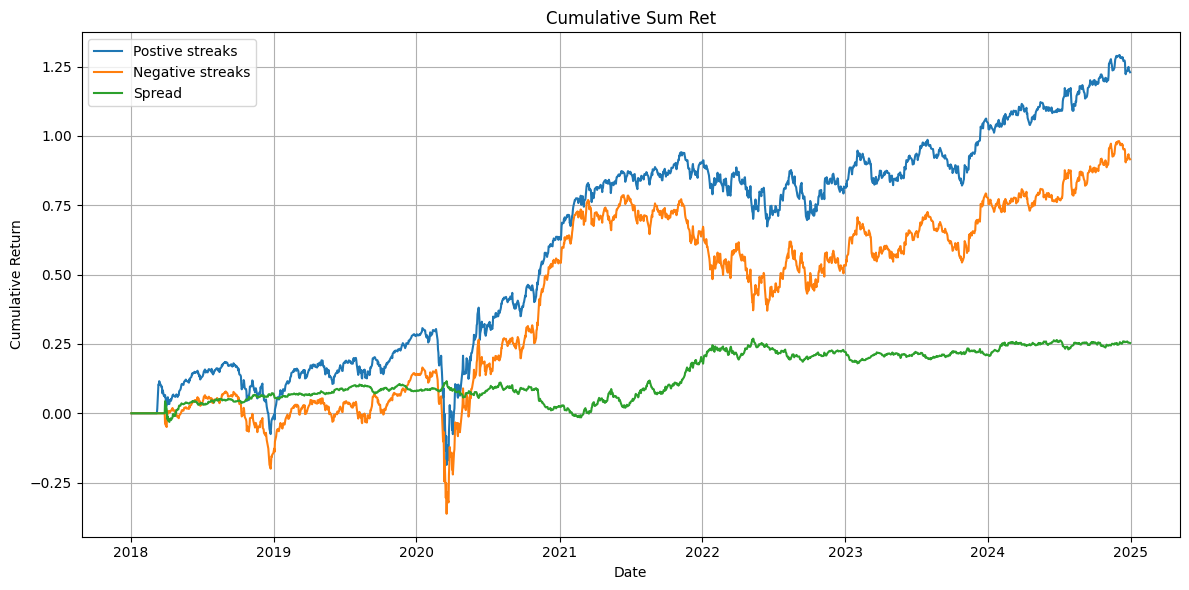

In [27]:
import matplotlib.pyplot as plt

df = daily_returns.to_pandas()

plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["long_cumret"], label="Postive streaks")
plt.plot(df["date"], df["short_cumret"], label="Negative streaks")
plt.plot(df["date"], df["spread_cumret"], label="Spread")
plt.title("Cumulative Sum Ret")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### 4 factor regression for sign portfolios

In [28]:
pl.Config.set_tbl_rows(10)

factors = pl.read_csv(
    r"/home/porter77/earnings-streak/sf-trading-system/research/example/streaks/factors.csv"
)

# the factors are monthly but the returns are for the portfolios are daily


factors = factors.with_columns(pl.col("caldt").str.strptime(pl.Date, "%Y-%m-%d").alias("date"))

factors = factors.drop(pl.col("caldt"))

factormodel = ret.join(factors, on="date")
factormodel

date,long_ret,short_ret,spread,exmkt,smb,hml,umd,rf
date,f64,f64,f64,f64,f64,f64,f64,f64
2018-01-31,null,null,null,5.57,-3.12,-1.28,4.05,0.12
2018-02-28,null,null,null,-3.65,0.26,-1.04,3.55,0.11
2018-03-29,0.005372,-0.038035,0.043407,-2.35,4.06,-0.2,-1.13,0.11
2018-04-30,-0.009099,-0.009824,0.000725,0.29,1.13,0.54,0.37,0.14
2018-05-31,-0.005447,-0.006254,0.000807,2.65,5.26,-3.22,3.87,0.14
…,…,…,…,…,…,…,…,…
2024-05-31,0.007888,0.010709,-0.002822,4.34,0.78,-1.67,-0.02,0.44
2024-06-28,0.006474,0.008489,-0.002016,2.77,-3.06,-3.31,0.9,0.41
2024-07-31,0.006994,0.004661,0.002333,1.24,6.8,5.74,-2.42,0.45


In [29]:
pl.Config.set_tbl_rows(10)

monthly_ret = monthly_ret.rename({"last_date_of_month": "date"})
monthly_ret = monthly_ret.drop(pl.col("month"))
monthly_ret = monthly_ret.join(factormodel, on="date")


monthly_ret

date,monthly_long_ret,monthly_short_ret,monthly_spread_ret,long_ret,short_ret,spread,exmkt,smb,hml,umd,rf
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2018-01-31,null,null,null,null,null,null,5.57,-3.12,-1.28,4.05,0.12
2018-02-28,null,null,null,null,null,null,-3.65,0.26,-1.04,3.55,0.11
2018-03-29,6.588868,-3.8035,4.340737,0.005372,-0.038035,0.043407,-2.35,4.06,-0.2,-1.13,0.11
2018-04-30,-0.703071,2.364108,-3.067179,-0.009099,-0.009824,0.000725,0.29,1.13,0.54,0.37,0.14
2018-05-31,5.865424,3.47895,2.386474,-0.005447,-0.006254,0.000807,2.65,5.26,-3.22,3.87,0.14
…,…,…,…,…,…,…,…,…,…,…,…
2024-05-31,4.499051,4.429733,0.069319,0.007888,0.010709,-0.002822,4.34,0.78,-1.67,-0.02,0.44
2024-06-28,-0.66376,-1.358549,0.694789,0.006474,0.008489,-0.002016,2.77,-3.06,-3.31,0.9,0.41
2024-07-31,7.508029,9.575827,-2.067798,0.006994,0.004661,0.002333,1.24,6.8,5.74,-2.42,0.45


In [30]:
import polars as pl
import statsmodels.api as sm

# Convert to pandas
df = monthly_ret.to_pandas()

# Drop rows with missing values
df = df.dropna(subset=["monthly_long_ret", "exmkt", "smb", "hml", "umd", "rf"])

# Compute excess return
df["excess_long"] = df["monthly_long_ret"] - df["rf"]

# Independent variables
X = df[["exmkt", "smb", "hml", "umd"]]
X = sm.add_constant(X)  # Add alpha/intercept

# Dependent variable
y = df["excess_long"]

# Fit model
model = sm.OLS(y, X).fit()

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            excess_long   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     552.4
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           2.87e-54
Time:                        16:06:42   Log-Likelihood:                -119.80
No. Observations:                  79   AIC:                             249.6
Df Residuals:                      74   BIC:                             261.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5156      0.132      3.910      0.0

In [31]:
import polars as pl
import statsmodels.api as sm

# Convert to pandas
df = monthly_ret.to_pandas()

# Drop rows with missing values
df = df.dropna(subset=["monthly_short_ret", "exmkt", "smb", "hml", "umd", "rf"])

# Compute excess return
df["excess_short"] = df["monthly_short_ret"] - df["rf"]

# Independent variables
X = df[["exmkt", "smb", "hml", "umd"]]
X = sm.add_constant(X)  # Add alpha/intercept

# Dependent variable
y = df["excess_short"]

# Fit model
model = sm.OLS(y, X).fit()

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           excess_short   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     284.8
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           4.05e-44
Time:                        16:06:42   Log-Likelihood:                -153.90
No. Observations:                  79   AIC:                             317.8
Df Residuals:                      74   BIC:                             329.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1319      0.203      0.650      0.5

In [32]:
import polars as pl
import statsmodels.api as sm

# Convert to pandas
df = monthly_ret.to_pandas()

# Drop rows with missing values
df = df.dropna(subset=["monthly_spread_ret", "exmkt", "smb", "hml", "umd", "rf"])

# Compute excess return
df["excess_spread"] = df["monthly_spread_ret"] - df["rf"]

# Independent variables
X = df[["exmkt", "smb", "hml", "umd"]]
X = sm.add_constant(X)  # Add alpha/intercept

# Dependent variable
y = df["excess_spread"]

# Fit model
model = sm.OLS(y, X).fit()

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_spread   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     6.396
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           0.000178
Time:                        16:06:42   Log-Likelihood:                -152.32
No. Observations:                  79   AIC:                             314.6
Df Residuals:                      74   BIC:                             326.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1013      0.199      0.509      0.6

### Magnitude portfolios

#### get holdings

In [33]:
# qcut the surpsignal and make it so that there is magnitude

totalMerge = totalMerge.with_columns(
    (pl.col("surpsignal").qcut(10, labels=[str(i) for i in range(10)]).alias("port"))
)

In [34]:
from datetime import timedelta
from tqdm import tqdm

# Get all trading dates
keys = sorted(totalMerge["date"].unique().to_list())
keys_set = set(keys)

# Build a dictionary mapping (date, ncusip) to return
returns_lookup = {
    (row["date"], row["ncusip"]): row["ret"]
    for row in totalMerge.select(["date", "ncusip", "ret"]).to_dicts()
}

# Initialize the long holdings dictionary
long_holdings_by_date = {k: [] for k in keys}

# Loop over all signal dates
for date in tqdm(keys, desc="Building long holdings"):
    sub = totalMerge.filter(
        (pl.col("date") == date) & (pl.col("streak") == 1) & (pl.col("port") == "9")
    )
    ncusips = sub.select("ncusip").to_series().to_list()

    for i in range(183):  # roughly 6 months
        future_day = date + timedelta(days=i)
        if future_day not in keys_set:
            continue

        for ncusip in ncusips:
            ret = returns_lookup.get((future_day, ncusip))
            if ret is not None:
                long_holdings_by_date[future_day].append({"ncusip": ncusip, "ret": ret})

Building long holdings: 100%|██████████| 1760/1760 [00:27<00:00, 64.70it/s]


In [35]:
from datetime import timedelta
from tqdm import tqdm

# Get all trading dates
keys = sorted(totalMerge["date"].unique().to_list())
keys_set = set(keys)

# Build a dictionary mapping (date, ncusip) to return
returns_lookup = {
    (row["date"], row["ncusip"]): row["ret"]
    for row in totalMerge.select(["date", "ncusip", "ret"]).to_dicts()
}

# Initialize the long holdings dictionary
short_holdings_by_date = {k: [] for k in keys}

# Loop over all signal dates
for date in tqdm(keys, desc="Building short holdings"):
    sub = totalMerge.filter(
        (pl.col("date") == date) & (pl.col("streak") == -1) & (pl.col("port") == "0")
    )
    ncusips = sub.select("ncusip").to_series().to_list()

    for i in range(183):  # roughly 6 months
        future_day = date + timedelta(days=i)
        if future_day not in keys_set:
            continue

        for ncusip in ncusips:
            ret = returns_lookup.get((future_day, ncusip))
            if ret is not None:
                short_holdings_by_date[future_day].append({"ncusip": ncusip, "ret": ret})

Building short holdings: 100%|██████████| 1760/1760 [00:25<00:00, 68.46it/s]


In [36]:
from statistics import mean

long_mean_returns_by_date = {}

for date, holdings in long_holdings_by_date.items():
    # Dictionary to store the most recent return for each ncusip (or just first one)
    ret_by_ncusip = {}
    for entry in holdings:
        ncusip = entry["ncusip"]
        ret = entry["ret"]
        if ret is not None:
            ret_by_ncusip[ncusip] = ret  # overwrite or keep only one value per ncusip

    if ret_by_ncusip:
        long_mean_returns_by_date[date] = mean(ret_by_ncusip.values())
    else:
        long_mean_returns_by_date[date] = None  # or 0.0 if you prefer

In [37]:
from statistics import mean

short_mean_returns_by_date = {}

for date, holdings in short_holdings_by_date.items():
    # Dictionary to store the most recent return for each ncusip (or just first one)
    ret_by_ncusip = {}
    for entry in holdings:
        ncusip = entry["ncusip"]
        ret = entry["ret"]
        if ret is not None:
            ret_by_ncusip[ncusip] = ret  # overwrite or keep only one value per ncusip

    if ret_by_ncusip:
        short_mean_returns_by_date[date] = mean(ret_by_ncusip.values())
    else:
        short_mean_returns_by_date[date] = None  # or 0.0 if you prefer

In [38]:
pl.Config.set_tbl_rows(10)

short_n_holdings_by_date = {
    date: len(set(entry["ncusip"] for entry in holdings))
    for date, holdings in short_holdings_by_date.items()
}

import polars as pl

short = pl.DataFrame(
    {
        "date": list(short_n_holdings_by_date.keys()),
        "n_short_holdings": list(short_n_holdings_by_date.values()),
    }
).sort("date")


long_n_holdings_by_date = {
    date: len(set(entry["ncusip"] for entry in holdings))
    for date, holdings in long_holdings_by_date.items()
}

import polars as pl

long = pl.DataFrame(
    {
        "date": list(long_n_holdings_by_date.keys()),
        "n_long_holdings": list(long_n_holdings_by_date.values()),
    }
).sort("date")

total = long.join(short, on="date")
total = total.with_columns(
    (pl.col("n_long_holdings") + pl.col("n_short_holdings")).alias("total_holdings")
)
total

date,n_long_holdings,n_short_holdings,total_holdings
date,i64,i64,i64
2018-01-02,0,0,0
2018-01-03,0,0,0
2018-01-04,0,0,0
2018-01-05,0,0,0
2018-01-08,0,0,0
…,…,…,…
2024-12-23,229,237,466
2024-12-24,231,239,470
2024-12-26,229,240,469


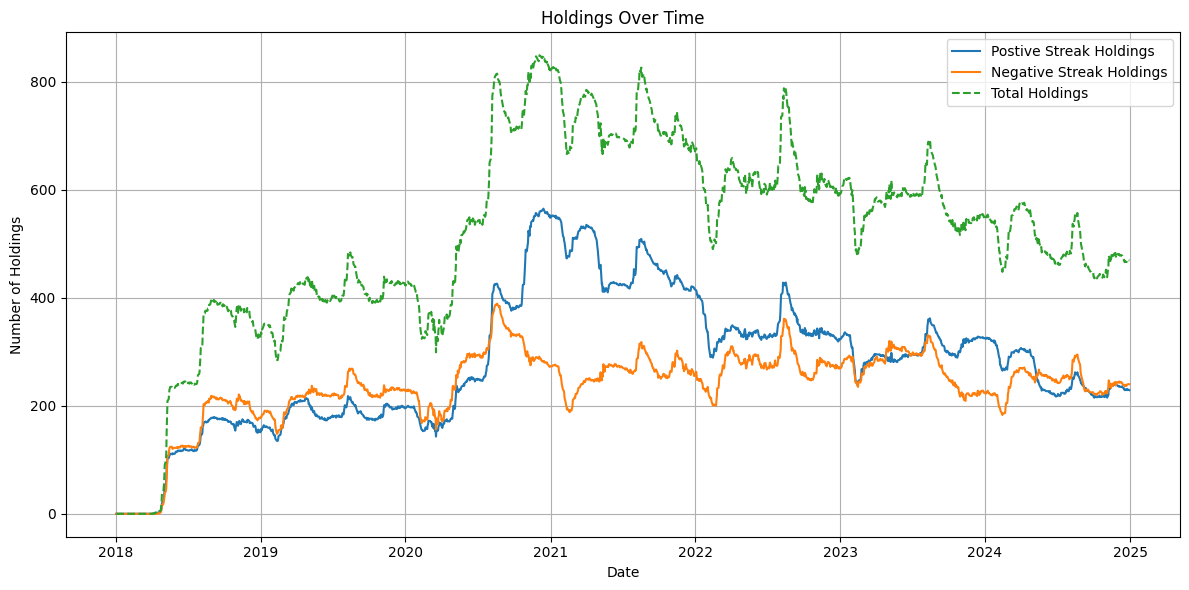

In [39]:
import matplotlib.pyplot as plt

# If your DataFrame is Polars:
df_pd = total.to_pandas()

plt.figure(figsize=(12, 6))

plt.plot(df_pd["date"], df_pd["n_long_holdings"], label="Postive Streak Holdings")
plt.plot(df_pd["date"], df_pd["n_short_holdings"], label="Negative Streak Holdings")
plt.plot(df_pd["date"], df_pd["total_holdings"], label="Total Holdings", linestyle="--")

plt.title("Holdings Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Holdings")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### get returns

In [40]:
import polars as pl

ret = pl.DataFrame(
    {
        "date": keys,  # same keys used for both dictionaries
        "long_ret": [long_mean_returns_by_date.get(k) for k in keys],
        "short_ret": [short_mean_returns_by_date.get(k) for k in keys],
    }
).sort("date")

ret = ret.with_columns(((pl.col("long_ret")) - (pl.col("short_ret"))).alias("spread"))

In [41]:
import polars as pl

monthly_ret = (
    ret.with_columns([pl.col("date").dt.truncate("1mo").alias("month")])
    .with_columns(
        [
            pl.col("long_ret").cum_sum().over("month").alias("long_monthly_ret"),
            pl.col("short_ret").cum_sum().over("month").alias("short_monthly_ret"),
            pl.col("spread").cum_sum().over("month").alias("spread_monthly_ret"),
        ]
    )
    .group_by("month")
    .agg(
        [
            pl.last("date").alias("last_date_of_month"),
            pl.last("long_monthly_ret").alias("monthly_long_ret"),
            pl.last("short_monthly_ret").alias("monthly_short_ret"),
            pl.last("spread_monthly_ret").alias("monthly_spread_ret"),
        ]
    )
    .sort("month")
)


# note the monthly ret is in decimal space, the factors from diether are in percent space

monthly_ret = monthly_ret.with_columns((pl.col("monthly_long_ret") * 100).alias("monthly_long_ret"))
monthly_ret = monthly_ret.with_columns(
    (pl.col("monthly_short_ret") * 100).alias("monthly_short_ret")
)
monthly_ret = monthly_ret.with_columns(
    (pl.col("monthly_spread_ret") * 100).alias("monthly_spread_ret")
)


monthly_ret

month,last_date_of_month,monthly_long_ret,monthly_short_ret,monthly_spread_ret
date,date,f64,f64,f64
2018-01-01,2018-01-31,null,null,null
2018-02-01,2018-02-28,null,null,null
2018-03-01,2018-03-29,null,null,null
2018-04-01,2018-04-30,-2.090751,-10.43238,15.095179
2018-05-01,2018-05-31,12.706378,1.73929,10.967088
…,…,…,…,…
2024-08-01,2024-08-30,0.395771,-1.835235,2.231006
2024-09-01,2024-09-30,3.424132,2.669463,0.754668
2024-10-01,2024-10-31,0.66007,0.873447,-0.213377


In [42]:
pl.Config.set_tbl_rows(10)
daily_returns = ret.with_columns(
    [
        pl.col("long_ret").fill_null(0).alias("long_ret_filled"),
        pl.col("short_ret").fill_null(0).alias("short_ret_filled"),
        pl.col("spread").fill_null(0).alias("spread_ret_filled"),
    ]
)

daily_returns = daily_returns.with_columns(
    [
        daily_returns["long_ret_filled"].cum_sum().alias("long_cumret"),
        daily_returns["short_ret_filled"].cum_sum().alias("short_cumret"),
        daily_returns["spread_ret_filled"].cum_sum().alias("spread_cumret"),
    ]
)

daily_returns

date,long_ret,short_ret,spread,long_ret_filled,short_ret_filled,spread_ret_filled,long_cumret,short_cumret,spread_cumret
date,f64,f64,f64,f64,f64,f64,f64,f64,f64
2018-01-02,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-04,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-05,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-08,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…
2024-12-23,0.006374,-0.00005,0.006424,0.006374,-0.00005,0.006424,1.819813,0.99277,0.894579
2024-12-24,0.009969,0.016566,-0.006596,0.009969,0.016566,-0.006596,1.829782,1.009335,0.887982
2024-12-26,0.013351,0.011168,0.002183,0.013351,0.011168,0.002183,1.843133,1.020503,0.890166


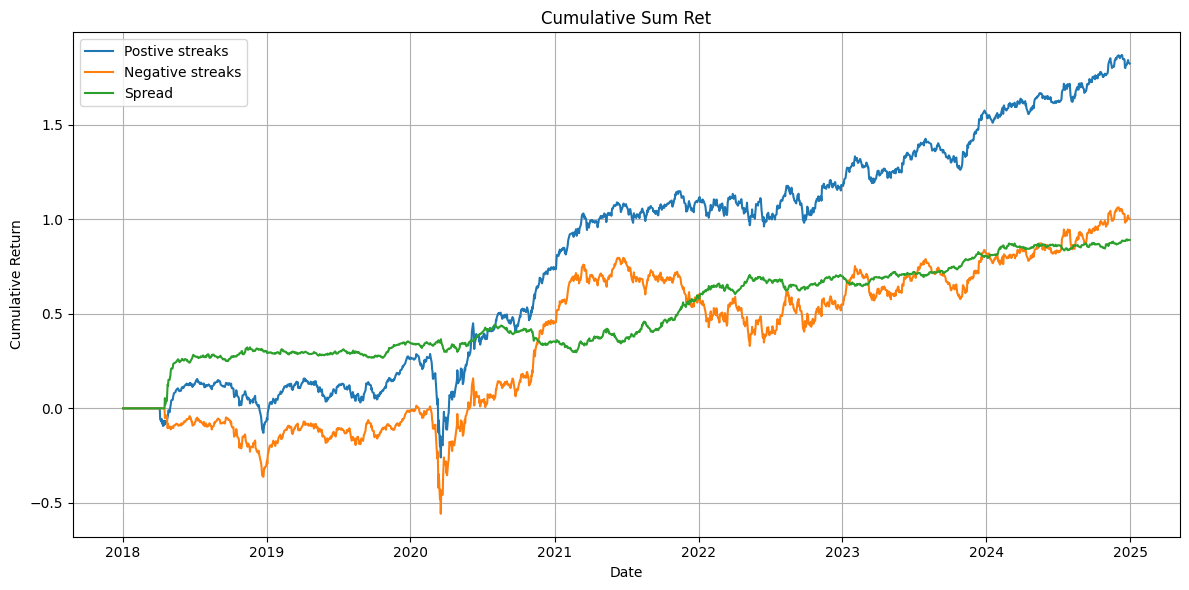

In [43]:
import matplotlib.pyplot as plt

df = daily_returns.to_pandas()

plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["long_cumret"], label="Postive streaks")
plt.plot(df["date"], df["short_cumret"], label="Negative streaks")
plt.plot(df["date"], df["spread_cumret"], label="Spread")
plt.title("Cumulative Sum Ret")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Four factor reg for magnitude

In [44]:
factors = pl.read_csv(
    r"/home/porter77/earnings-streak/sf-trading-system/research/example/streaks/factors.csv"
)

# the factors are monthly but the returns are for the portfolios are daily


factors = factors.with_columns(pl.col("caldt").str.strptime(pl.Date, "%Y-%m-%d").alias("date"))

factors = factors.drop(pl.col("caldt"))

factormodel = ret.join(factors, on="date")
factormodel

date,long_ret,short_ret,spread,exmkt,smb,hml,umd,rf
date,f64,f64,f64,f64,f64,f64,f64,f64
2018-01-31,null,null,null,5.57,-3.12,-1.28,4.05,0.12
2018-02-28,null,null,null,-3.65,0.26,-1.04,3.55,0.11
2018-03-29,null,null,null,-2.35,4.06,-0.2,-1.13,0.11
2018-04-30,-0.010539,-0.010634,0.000095,0.29,1.13,0.54,0.37,0.14
2018-05-31,-0.000063,-0.007478,0.007415,2.65,5.26,-3.22,3.87,0.14
…,…,…,…,…,…,…,…,…
2024-05-31,0.005388,0.011991,-0.006603,4.34,0.78,-1.67,-0.02,0.44
2024-06-28,0.005492,0.007893,-0.0024,2.77,-3.06,-3.31,0.9,0.41
2024-07-31,0.008228,0.00644,0.001788,1.24,6.8,5.74,-2.42,0.45


In [45]:
monthly_ret = monthly_ret.rename({"last_date_of_month": "date"})
monthly_ret = monthly_ret.drop(pl.col("month"))
monthly_ret = monthly_ret.join(factormodel, on="date")


monthly_ret

date,monthly_long_ret,monthly_short_ret,monthly_spread_ret,long_ret,short_ret,spread,exmkt,smb,hml,umd,rf
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2018-01-31,null,null,null,null,null,null,5.57,-3.12,-1.28,4.05,0.12
2018-02-28,null,null,null,null,null,null,-3.65,0.26,-1.04,3.55,0.11
2018-03-29,null,null,null,null,null,null,-2.35,4.06,-0.2,-1.13,0.11
2018-04-30,-2.090751,-10.43238,15.095179,-0.010539,-0.010634,0.000095,0.29,1.13,0.54,0.37,0.14
2018-05-31,12.706378,1.73929,10.967088,-0.000063,-0.007478,0.007415,2.65,5.26,-3.22,3.87,0.14
…,…,…,…,…,…,…,…,…,…,…,…
2024-05-31,6.257662,6.219941,0.037721,0.005388,0.011991,-0.006603,4.34,0.78,-1.67,-0.02,0.44
2024-06-28,-2.358935,-2.702352,0.343417,0.005492,0.007893,-0.0024,2.77,-3.06,-3.31,0.9,0.41
2024-07-31,9.135182,10.817839,-1.682657,0.008228,0.00644,0.001788,1.24,6.8,5.74,-2.42,0.45


In [46]:
import polars as pl
import statsmodels.api as sm

# Convert to pandas
df = monthly_ret.to_pandas()

# Drop rows with missing values
df = df.dropna(subset=["monthly_long_ret", "exmkt", "smb", "hml", "umd", "rf"])

# Compute excess return
df["excess_long"] = df["monthly_long_ret"] - df["rf"]

# Independent variables
X = df[["exmkt", "smb", "hml", "umd"]]
X = sm.add_constant(X)  # Add alpha/intercept

# Dependent variable
y = df["excess_long"]

# Fit model
model = sm.OLS(y, X).fit()

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            excess_long   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     215.3
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           1.35e-39
Time:                        16:08:29   Log-Likelihood:                -166.64
No. Observations:                  78   AIC:                             343.3
Df Residuals:                      73   BIC:                             355.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2367      0.248      4.986      0.0

In [47]:
import polars as pl
import statsmodels.api as sm

# Convert to pandas
df = monthly_ret.to_pandas()

# Drop rows with missing values
df = df.dropna(subset=["monthly_short_ret", "exmkt", "smb", "hml", "umd", "rf"])

# Compute excess return
df["excess_short"] = df["monthly_short_ret"] - df["rf"]

# Independent variables
X = df[["exmkt", "smb", "hml", "umd"]]
X = sm.add_constant(X)  # Add alpha/intercept

# Dependent variable
y = df["excess_short"]

# Fit model
model = sm.OLS(y, X).fit()

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           excess_short   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     123.4
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           1.07e-31
Time:                        16:08:30   Log-Likelihood:                -190.94
No. Observations:                  78   AIC:                             391.9
Df Residuals:                      73   BIC:                             403.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3162      0.339      0.934      0.3

In [48]:
import polars as pl
import statsmodels.api as sm

# Convert to pandas
df = monthly_ret.to_pandas()

# Drop rows with missing values
df = df.dropna(subset=["monthly_spread_ret", "exmkt", "smb", "hml", "umd", "rf"])

# Compute excess return
df["excess_spread"] = df["monthly_spread_ret"] - df["rf"]

# Independent variables
X = df[["exmkt", "smb", "hml", "umd"]]
X = sm.add_constant(X)  # Add alpha/intercept

# Dependent variable
y = df["excess_spread"]

# Fit model
model = sm.OLS(y, X).fit()

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_spread   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.541
Date:                Wed, 02 Apr 2025   Prob (F-statistic):              0.199
Time:                        16:08:30   Log-Likelihood:                -197.99
No. Observations:                  78   AIC:                             406.0
Df Residuals:                      73   BIC:                             417.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8349      0.371      2.252      0.0

### Portfolios with 3 month holding period

In [49]:
keys = sorted(totalMerge["date"].unique().to_list())
keys_set = set(keys)

# Build a dictionary mapping (date, ncusip) to return
returns_lookup = {
    (row["date"], row["ncusip"]): row["ret"]
    for row in totalMerge.select(["date", "ncusip", "ret"]).to_dicts()
}

# Initialize the long holdings dictionary
long_holdings_by_date = {k: [] for k in keys}

# Loop over all signal dates
for date in tqdm(keys, desc="Building long holdings"):
    sub = totalMerge.filter(
        (pl.col("date") == date) & (pl.col("streak") == 1) & (pl.col("port") == "9")
    )
    ncusips = sub.select("ncusip").to_series().to_list()

    for i in range(89):  # 3 months ish
        future_day = date + timedelta(days=i)
        if future_day not in keys_set:
            continue

        for ncusip in ncusips:
            ret = returns_lookup.get((future_day, ncusip))
            if ret is not None:
                long_holdings_by_date[future_day].append({"ncusip": ncusip, "ret": ret})

Building long holdings: 100%|██████████| 1760/1760 [00:24<00:00, 70.54it/s]


In [50]:
keys = sorted(totalMerge["date"].unique().to_list())
keys_set = set(keys)

# Build a dictionary mapping (date, ncusip) to return
returns_lookup = {
    (row["date"], row["ncusip"]): row["ret"]
    for row in totalMerge.select(["date", "ncusip", "ret"]).to_dicts()
}

# Initialize the long holdings dictionary
short_holdings_by_date = {k: [] for k in keys}

# Loop over all signal dates
for date in tqdm(keys, desc="Building short holdings"):
    sub = totalMerge.filter(
        (pl.col("date") == date) & (pl.col("streak") == -1) & (pl.col("port") == "0")
    )
    ncusips = sub.select("ncusip").to_series().to_list()

    for i in range(89):
        future_day = date + timedelta(days=i)
        if future_day not in keys_set:
            continue

        for ncusip in ncusips:
            ret = returns_lookup.get((future_day, ncusip))
            if ret is not None:
                short_holdings_by_date[future_day].append({"ncusip": ncusip, "ret": ret})

Building short holdings: 100%|██████████| 1760/1760 [00:25<00:00, 69.17it/s]


In [51]:
from statistics import mean

long_mean_returns_by_date = {}

for date, holdings in long_holdings_by_date.items():
    # Dictionary to store the most recent return for each ncusip (or just first one)
    ret_by_ncusip = {}
    for entry in holdings:
        ncusip = entry["ncusip"]
        ret = entry["ret"]
        if ret is not None:
            ret_by_ncusip[ncusip] = ret  # overwrite or keep only one value per ncusip

    if ret_by_ncusip:
        long_mean_returns_by_date[date] = mean(ret_by_ncusip.values())
    else:
        long_mean_returns_by_date[date] = None  # or 0.0 if you prefer

In [52]:
from statistics import mean

short_mean_returns_by_date = {}

for date, holdings in short_holdings_by_date.items():
    # Dictionary to store the most recent return for each ncusip (or just first one)
    ret_by_ncusip = {}
    for entry in holdings:
        ncusip = entry["ncusip"]
        ret = entry["ret"]
        if ret is not None:
            ret_by_ncusip[ncusip] = ret  # overwrite or keep only one value per ncusip

    if ret_by_ncusip:
        short_mean_returns_by_date[date] = mean(ret_by_ncusip.values())
    else:
        short_mean_returns_by_date[date] = None  # or 0.0 if you prefer

In [53]:
short_n_holdings_by_date = {
    date: len(set(entry["ncusip"] for entry in holdings))
    for date, holdings in short_holdings_by_date.items()
}

import polars as pl

short = pl.DataFrame(
    {
        "date": list(short_n_holdings_by_date.keys()),
        "n_short_holdings": list(short_n_holdings_by_date.values()),
    }
).sort("date")


long_n_holdings_by_date = {
    date: len(set(entry["ncusip"] for entry in holdings))
    for date, holdings in long_holdings_by_date.items()
}

import polars as pl

long = pl.DataFrame(
    {
        "date": list(long_n_holdings_by_date.keys()),
        "n_long_holdings": list(long_n_holdings_by_date.values()),
    }
).sort("date")

total = long.join(short, on="date")
total = total.with_columns(
    (pl.col("n_long_holdings") + pl.col("n_short_holdings")).alias("total_holdings")
)
total

date,n_long_holdings,n_short_holdings,total_holdings
date,i64,i64,i64
2018-01-02,0,0,0
2018-01-03,0,0,0
2018-01-04,0,0,0
2018-01-05,0,0,0
2018-01-08,0,0,0
…,…,…,…
2024-12-23,148,158,306
2024-12-24,149,160,309
2024-12-26,147,159,306


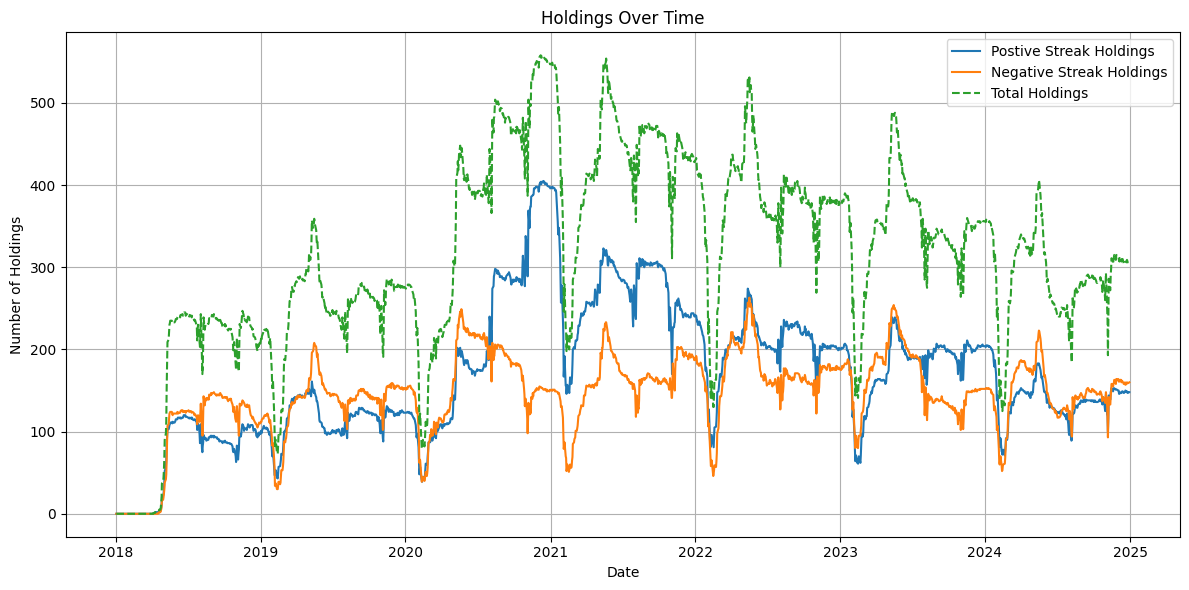

In [54]:
import matplotlib.pyplot as plt

# If your DataFrame is Polars:
df_pd = total.to_pandas()

plt.figure(figsize=(12, 6))

plt.plot(df_pd["date"], df_pd["n_long_holdings"], label="Postive Streak Holdings")
plt.plot(df_pd["date"], df_pd["n_short_holdings"], label="Negative Streak Holdings")
plt.plot(df_pd["date"], df_pd["total_holdings"], label="Total Holdings", linestyle="--")

plt.title("Holdings Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Holdings")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### returns

In [55]:
import polars as pl

ret = pl.DataFrame(
    {
        "date": keys,  # same keys used for both dictionaries
        "long_ret": [long_mean_returns_by_date.get(k) for k in keys],
        "short_ret": [short_mean_returns_by_date.get(k) for k in keys],
    }
).sort("date")

ret = ret.with_columns(((pl.col("long_ret")) - (pl.col("short_ret"))).alias("spread"))

In [56]:
import polars as pl

monthly_ret = (
    ret.with_columns([pl.col("date").dt.truncate("1mo").alias("month")])
    .with_columns(
        [
            pl.col("long_ret").cum_sum().over("month").alias("long_monthly_ret"),
            pl.col("short_ret").cum_sum().over("month").alias("short_monthly_ret"),
            pl.col("spread").cum_sum().over("month").alias("spread_monthly_ret"),
        ]
    )
    .group_by("month")
    .agg(
        [
            pl.last("date").alias("last_date_of_month"),
            pl.last("long_monthly_ret").alias("monthly_long_ret"),
            pl.last("short_monthly_ret").alias("monthly_short_ret"),
            pl.last("spread_monthly_ret").alias("monthly_spread_ret"),
        ]
    )
    .sort("month")
)


# note the monthly ret is in decimal space, the factors from diether are in percent space

monthly_ret = monthly_ret.with_columns((pl.col("monthly_long_ret") * 100).alias("monthly_long_ret"))
monthly_ret = monthly_ret.with_columns(
    (pl.col("monthly_short_ret") * 100).alias("monthly_short_ret")
)
monthly_ret = monthly_ret.with_columns(
    (pl.col("monthly_spread_ret") * 100).alias("monthly_spread_ret")
)


monthly_ret

month,last_date_of_month,monthly_long_ret,monthly_short_ret,monthly_spread_ret
date,date,f64,f64,f64
2018-01-01,2018-01-31,null,null,null
2018-02-01,2018-02-28,null,null,null
2018-03-01,2018-03-29,null,null,null
2018-04-01,2018-04-30,-2.090751,-10.43238,15.095179
2018-05-01,2018-05-31,12.706378,1.73929,10.967088
…,…,…,…,…
2024-08-01,2024-08-30,1.788709,-3.90565,5.694359
2024-09-01,2024-09-30,2.896096,1.650294,1.245802
2024-10-01,2024-10-31,0.37731,0.922831,-0.545521


In [57]:
pl.Config.set_tbl_rows(10)
daily_returns = ret.with_columns(
    [
        pl.col("long_ret").fill_null(0).alias("long_ret_filled"),
        pl.col("short_ret").fill_null(0).alias("short_ret_filled"),
        pl.col("spread").fill_null(0).alias("spread_ret_filled"),
    ]
)

daily_returns = daily_returns.with_columns(
    [
        daily_returns["long_ret_filled"].cum_sum().alias("long_cumret"),
        daily_returns["short_ret_filled"].cum_sum().alias("short_cumret"),
        daily_returns["spread_ret_filled"].cum_sum().alias("spread_cumret"),
    ]
)

daily_returns

date,long_ret,short_ret,spread,long_ret_filled,short_ret_filled,spread_ret_filled,long_cumret,short_cumret,spread_cumret
date,f64,f64,f64,f64,f64,f64,f64,f64,f64
2018-01-02,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-04,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-05,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-08,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…
2024-12-23,0.006368,-0.000352,0.00672,0.006368,-0.000352,0.00672,2.00543,0.552268,1.520697
2024-12-24,0.01148,0.018664,-0.007185,0.01148,0.018664,-0.007185,2.016909,0.570932,1.513513
2024-12-26,0.015927,0.009117,0.00681,0.015927,0.009117,0.00681,2.032836,0.580049,1.520322


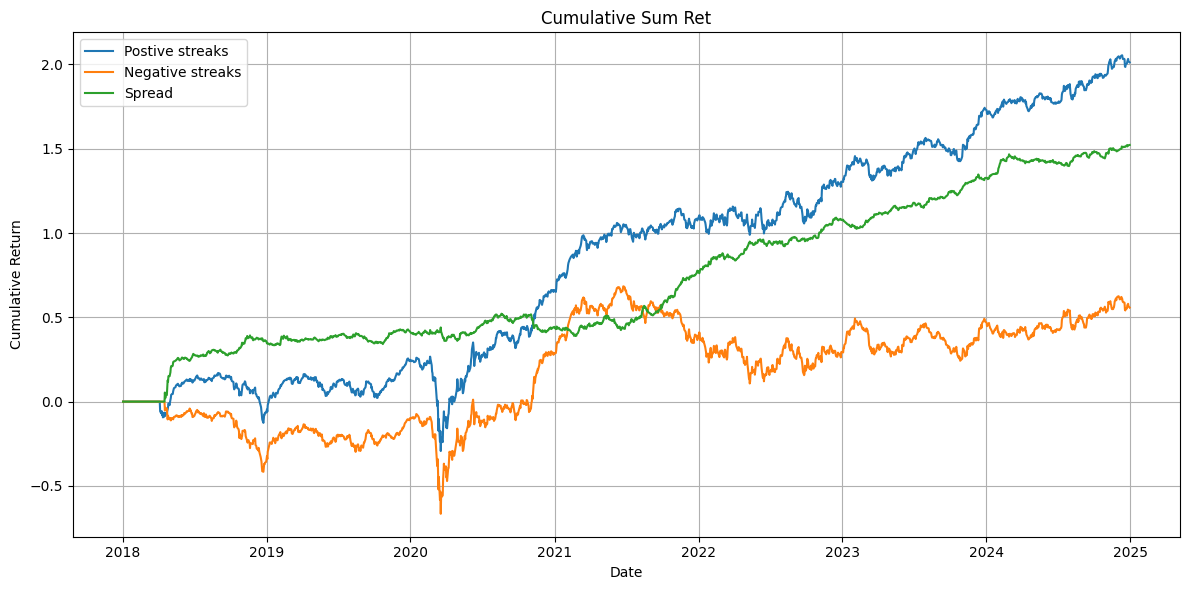

In [58]:
import matplotlib.pyplot as plt

df = daily_returns.to_pandas()

plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["long_cumret"], label="Postive streaks")
plt.plot(df["date"], df["short_cumret"], label="Negative streaks")
plt.plot(df["date"], df["spread_cumret"], label="Spread")
plt.title("Cumulative Sum Ret")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [59]:
factors = pl.read_csv(
    r"/home/porter77/earnings-streak/sf-trading-system/research/example/streaks/factors.csv"
)

# the factors are monthly but the returns are for the portfolios are daily


factors = factors.with_columns(pl.col("caldt").str.strptime(pl.Date, "%Y-%m-%d").alias("date"))

factors = factors.drop(pl.col("caldt"))

factormodel = ret.join(factors, on="date")
factormodel

date,long_ret,short_ret,spread,exmkt,smb,hml,umd,rf
date,f64,f64,f64,f64,f64,f64,f64,f64
2018-01-31,null,null,null,5.57,-3.12,-1.28,4.05,0.12
2018-02-28,null,null,null,-3.65,0.26,-1.04,3.55,0.11
2018-03-29,null,null,null,-2.35,4.06,-0.2,-1.13,0.11
2018-04-30,-0.010539,-0.010634,0.000095,0.29,1.13,0.54,0.37,0.14
2018-05-31,-0.000063,-0.007478,0.007415,2.65,5.26,-3.22,3.87,0.14
…,…,…,…,…,…,…,…,…
2024-05-31,0.004364,0.012603,-0.008239,4.34,0.78,-1.67,-0.02,0.44
2024-06-28,0.003661,0.007656,-0.003995,2.77,-3.06,-3.31,0.9,0.41
2024-07-31,0.013271,0.005287,0.007984,1.24,6.8,5.74,-2.42,0.45


In [60]:
monthly_ret = monthly_ret.rename({"last_date_of_month": "date"})
monthly_ret = monthly_ret.drop(pl.col("month"))
monthly_ret = monthly_ret.join(factormodel, on="date")


monthly_ret

date,monthly_long_ret,monthly_short_ret,monthly_spread_ret,long_ret,short_ret,spread,exmkt,smb,hml,umd,rf
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2018-01-31,null,null,null,null,null,null,5.57,-3.12,-1.28,4.05,0.12
2018-02-28,null,null,null,null,null,null,-3.65,0.26,-1.04,3.55,0.11
2018-03-29,null,null,null,null,null,null,-2.35,4.06,-0.2,-1.13,0.11
2018-04-30,-2.090751,-10.43238,15.095179,-0.010539,-0.010634,0.000095,0.29,1.13,0.54,0.37,0.14
2018-05-31,12.706378,1.73929,10.967088,-0.000063,-0.007478,0.007415,2.65,5.26,-3.22,3.87,0.14
…,…,…,…,…,…,…,…,…,…,…,…
2024-05-31,5.060022,6.683918,-1.623896,0.004364,0.012603,-0.008239,4.34,0.78,-1.67,-0.02,0.44
2024-06-28,-3.109011,-2.478114,-0.630897,0.003661,0.007656,-0.003995,2.77,-3.06,-3.31,0.9,0.41
2024-07-31,10.974266,11.058744,-0.084478,0.013271,0.005287,0.007984,1.24,6.8,5.74,-2.42,0.45


In [61]:
import polars as pl
import statsmodels.api as sm

# Convert to pandas
df = monthly_ret.to_pandas()

# Drop rows with missing values
df = df.dropna(subset=["monthly_long_ret", "exmkt", "smb", "hml", "umd", "rf"])

# Compute excess return
df["excess_long"] = df["monthly_long_ret"] - df["rf"]

# Independent variables
X = df[["exmkt", "smb", "hml", "umd"]]
X = sm.add_constant(X)  # Add alpha/intercept

# Dependent variable
y = df["excess_long"]

# Fit model
model = sm.OLS(y, X).fit()

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            excess_long   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     160.4
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           2.34e-35
Time:                        16:10:08   Log-Likelihood:                -178.07
No. Observations:                  78   AIC:                             366.1
Df Residuals:                      73   BIC:                             377.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4927      0.287      5.198      0.0

In [62]:
import polars as pl
import statsmodels.api as sm

# Convert to pandas
df = monthly_ret.to_pandas()

# Drop rows with missing values
df = df.dropna(subset=["monthly_short_ret", "exmkt", "smb", "hml", "umd", "rf"])

# Compute excess return
df["excess_short"] = df["monthly_short_ret"] - df["rf"]

# Independent variables
X = df[["exmkt", "smb", "hml", "umd"]]
X = sm.add_constant(X)  # Add alpha/intercept

# Dependent variable
y = df["excess_short"]

# Fit model
model = sm.OLS(y, X).fit()

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           excess_short   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     101.9
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           4.26e-29
Time:                        16:10:08   Log-Likelihood:                -200.21
No. Observations:                  78   AIC:                             410.4
Df Residuals:                      73   BIC:                             422.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2051      0.381     -0.538      0.5

In [63]:
import polars as pl
import statsmodels.api as sm

# Convert to pandas
df = monthly_ret.to_pandas()

# Drop rows with missing values
df = df.dropna(subset=["monthly_spread_ret", "exmkt", "smb", "hml", "umd", "rf"])

# Compute excess return
df["excess_spread"] = df["monthly_spread_ret"] - df["rf"]

# Independent variables
X = df[["exmkt", "smb", "hml", "umd"]]
X = sm.add_constant(X)  # Add alpha/intercept

# Dependent variable
y = df["excess_spread"]

# Fit model
model = sm.OLS(y, X).fit()

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_spread   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     2.622
Date:                Wed, 02 Apr 2025   Prob (F-statistic):             0.0416
Time:                        16:10:08   Log-Likelihood:                -208.36
No. Observations:                  78   AIC:                             426.7
Df Residuals:                      73   BIC:                             438.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6123      0.423      3.807      0.0